# 1. Download the LaTeX project

In [ ]:
import os
os.chdir('..')
!mkdir downloaded
!wget -O downloaded/1601.00978.tar.gz https://arxiv.org/e-print/1601.00978 --user-agent "Name <email>"

# 2. Check and Create LaTeX Compile Service

In [2]:
import docker
from texannotate.util import (find_free_port, find_latex_file, postprocess_latex,
                  preprocess_latex, tup2str)
import tarfile
client = docker.from_env()
try:
    client.images.get('tex-compilation-service:latest')
except docker.errors.ImageNotFound:
    client.images.build(path='texcompile/service', tag='tex-compilation-service')

port = find_free_port()
from sys import platform
if platform == "linux" or platform == "linux2":
    from memory_tempfile import MemoryTempfile
    tempfile = MemoryTempfile()
    container = client.containers.run(
        image='tex-compilation-service',
        detach=True,
        ports={'80/tcp':port},
        tmpfs={'/tmpfs':''},
        remove=True,
    )
else:
    import tempfile
    container = client.containers.run(
        image='tex-compilation-service',
        detach=True,
        ports={'80/tcp':port},
        #tmpfs={'/tmpfs':''},
        remove=True,
    )

# 3. Compile LaTeX project to Extract Original Colors

We can get the original compiled PDF file.

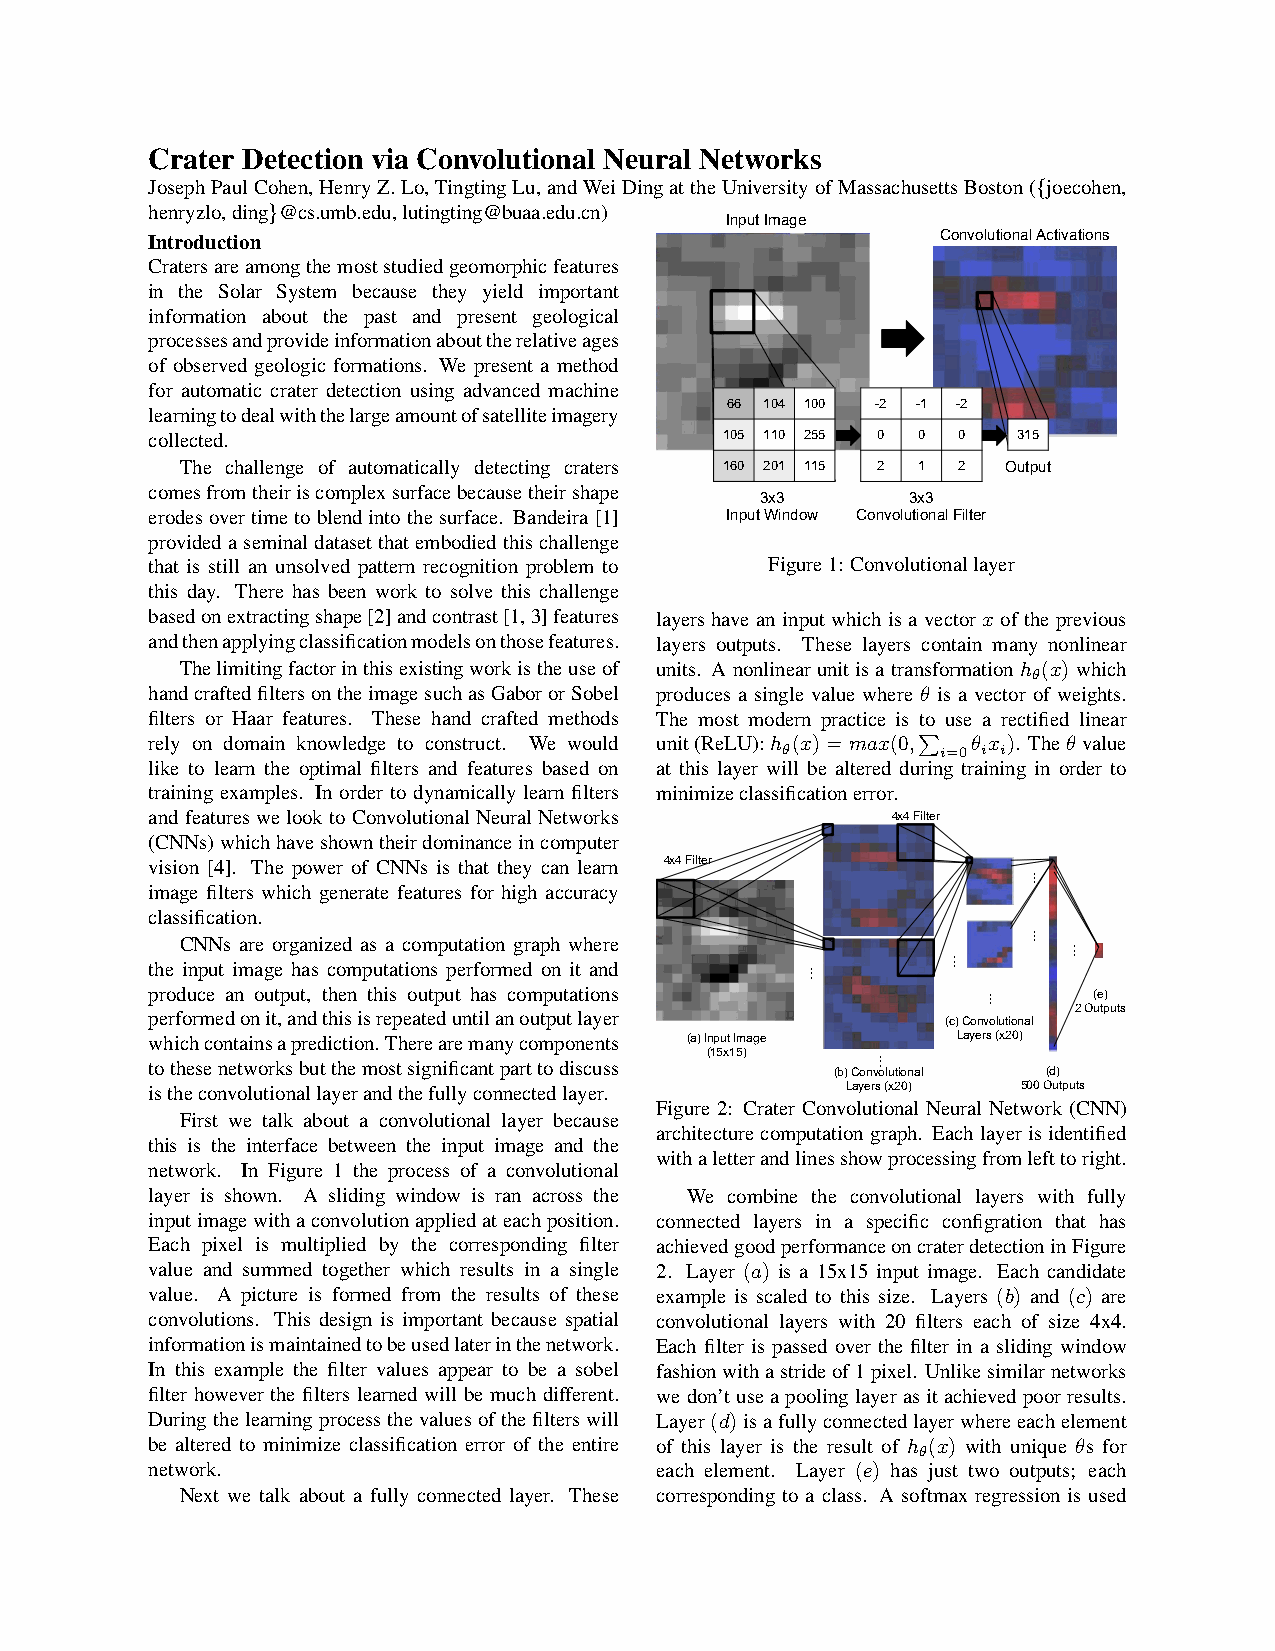

In [3]:
from texcompile.client import compile_pdf_return_bytes
from pdfextract.pdf_extract import pdf_extract
from texannotate.color_annotation import ColorAnnotation
import pdfplumber

with tempfile.TemporaryDirectory() as td:
    with tarfile.open('downloaded/1601.00978.tar.gz' ,'r:gz') as tar:
        tar.extractall(td)
        preprocess_latex(td)

    basename, pdf_bytes = compile_pdf_return_bytes(
        sources_dir=td
    ) # compile the unmodified latex firstly
    shapes, tokens = pdf_extract(pdf_bytes)
    color_dict = ColorAnnotation()
    for rect in shapes:
        color_dict.add_existing_color(tup2str(rect['stroking_color']))
    for token in tokens:
        color_dict.add_existing_color(token['color'])

with pdfplumber.open(pdf_bytes) as doc:
    p0 = doc.pages[0]
    im_origin = p0.to_image(resolution=150)
im_origin

# 4. Annotate the LaTeX project and Compile

Here we can get gradient color tokens and figures with different background colors.

start annotating: /run/user/1001/tmptuac35tv/cratercnn.tex
finish annotating: /run/user/1001/tmptuac35tv/cratercnn.tex


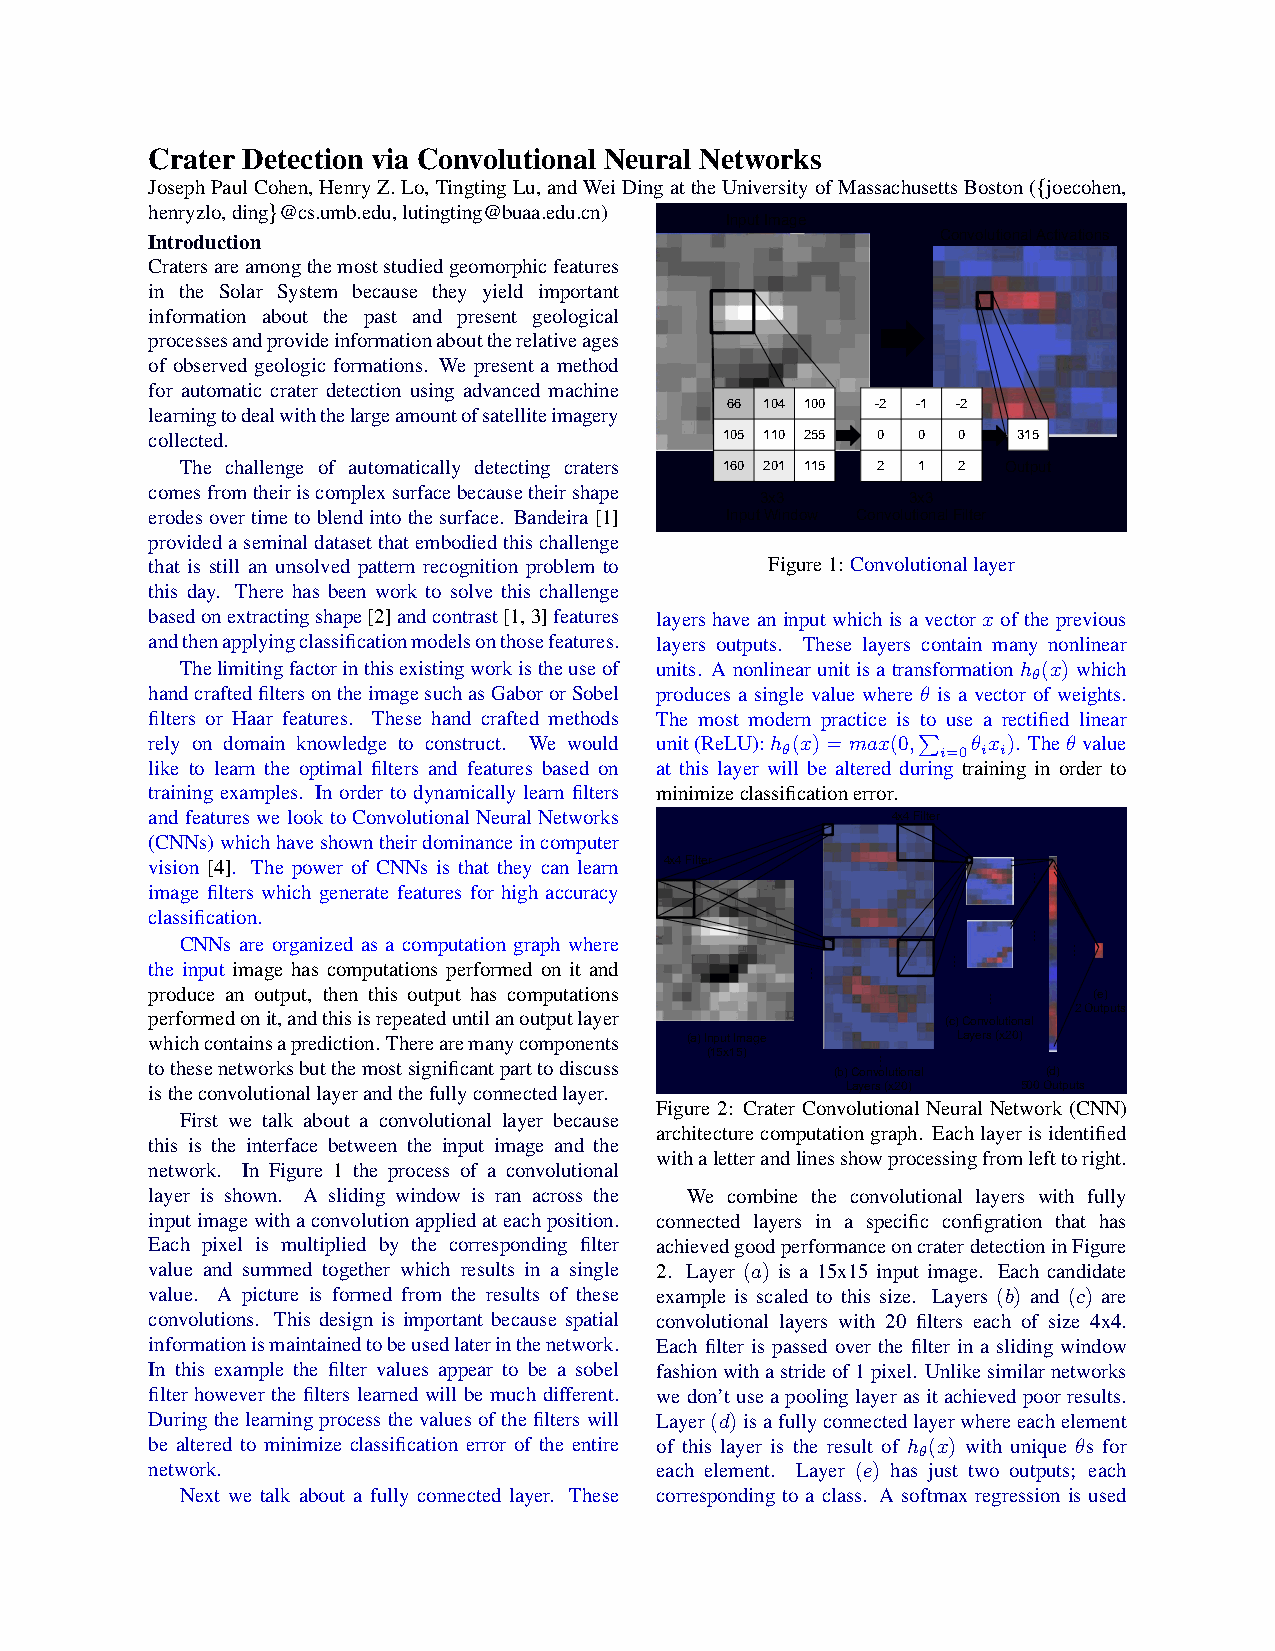

In [4]:
from pathlib import Path
from texannotate.annotate_file import annotate_file

with tempfile.TemporaryDirectory() as td:
    with tarfile.open('downloaded/1601.00978.tar.gz' ,'r:gz') as tar:
        tar.extractall(td)
    tex_file = find_latex_file(Path(basename).stem, basepath=td)
    annotate_file(tex_file, color_dict, latex_context=None, basepath=td)
    postprocess_latex(tex_file)
    #print(p/'outputs'/filename.stem)
    #shutil.make_archive(p/'outputs'/filename.stem, 'zip', td)
    basename, pdf_bytes = compile_pdf_return_bytes(
        sources_dir=td
    ) # compile the unmodified latex firstly
    shapes, tokens = pdf_extract(pdf_bytes)

with pdfplumber.open(pdf_bytes) as doc:
    p0 = doc.pages[0]
    im = p0.to_image(resolution=150)
im

# 5. Export annotations as DataFrame

Here we can see that the first 6 nodes are Table of Contents Nodes.
That is, there are 4 subsections in this paper, and they are all direct children of the title node.
The title is then a child node of the root node of the entire paper.

In [5]:

from pdfextract.export_annotation import export_annotation

df = export_annotation(shapes, tokens, color_dict)
df.head(20)

,reading_order,label,section,head,token,page,x0,y0,x1,y1,font,size,flags
0,-1,TOCNode,0,-1,None,0,0.000000,0.000000,0.000000,0.000000,None,0.0000,None
1,-1,TOCNode,0,1,None,0,0.000000,0.000000,0.000000,0.000000,None,0.0000,None
2,-1,TOCNode,1,2,None,0,0.000000,0.000000,0.000000,0.000000,None,0.0000,None
3,-1,TOCNode,1,3,None,0,0.000000,0.000000,0.000000,0.000000,None,0.0000,None
4,-1,TOCNode,1,4,None,0,0.000000,0.000000,0.000000,0.000000,None,0.0000,None
5,-1,TOCNode,1,5,None,0,0.000000,0.000000,0.000000,0.000000,None,0.0000,None
6,437,Figure,2,1,None,1,314.966000,97.603000,540.719000,255.423000,None,NaN,None
7,519,Figure,2,1,None,1,314.966000,386.967000,540.719000,524.608000,None,NaN,None
8,816,Figure,2,1,None,2,71.280000,71.280000,297.033000,130.738000,None,NaN,None
9,1154,Figure,3,1,None,2,316.988000,153.696000,389.231000,225.939000,None,NaN,None


# 6. Visualization of Annotations

In [6]:
colors = {
    "Abstract":(255, 182, 193), "Author":(0, 0, 139), "Caption":(57, 230, 10),
    "Equation":(255, 0, 0),"Figure":(230, 51, 249),"Footer":(255, 255, 255),
    "List":(46, 33, 109),"Paragraph":(181, 196, 220),"Reference":(81, 142, 32),
    "Section":(24, 14, 248),"Table":(129, 252, 254),"Title":(97, 189, 251)
}

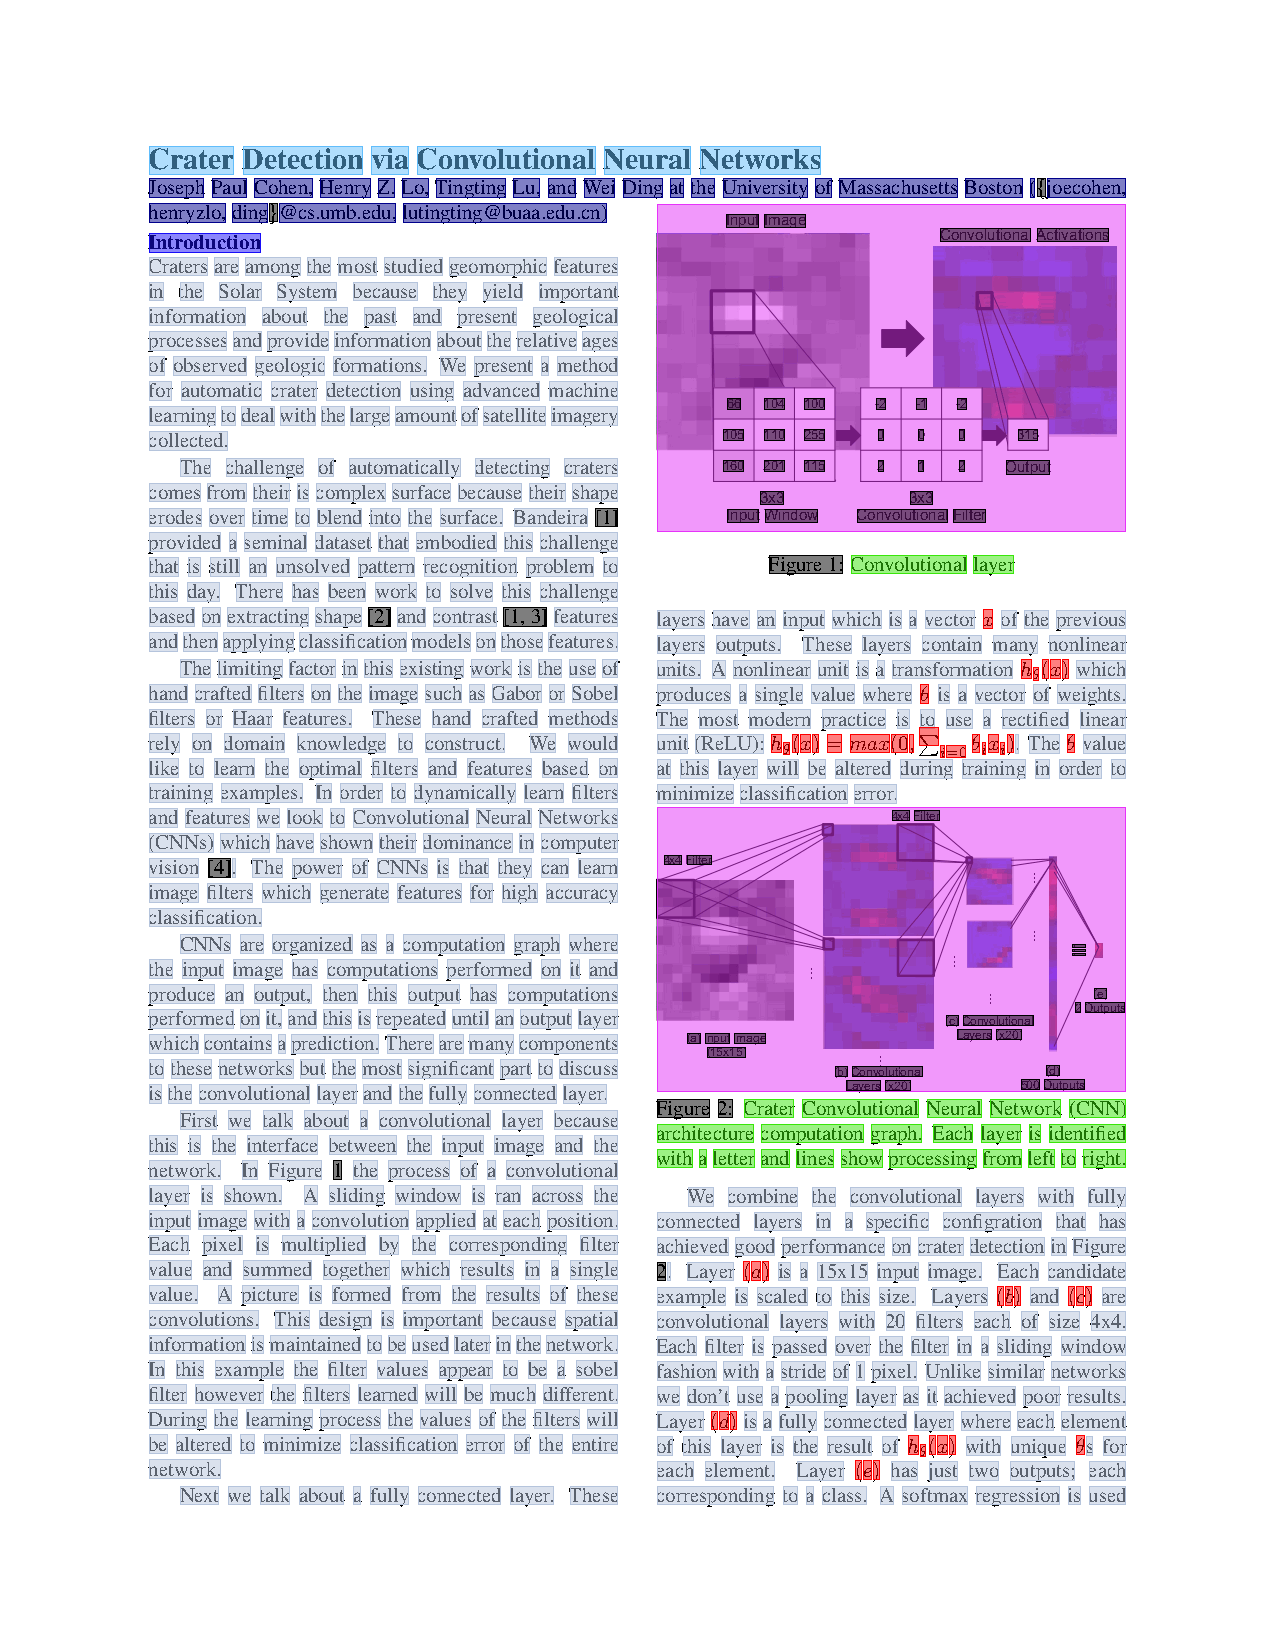

In [7]:
for i, rect in df.iterrows():
    if rect['page'] == 1:
        color = colors.get(rect['label'], (0,0,0))
        im_origin.draw_rect((rect['x0'], rect['y0'], rect['x1'], rect['y1']), fill=(color[0],color[1],color[2],128), stroke=color, stroke_width=1)
im_origin

# Clean the environment

In [10]:
container.stop()